# Importing required libraries and functions

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
#pip install -U scikit-learn
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
from numpy import mean
from numpy import std
import nibabel as nib
from nilearn.maskers import NiftiLabelsMasker
from nilearn import datasets
import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import re

/home/westbrookca2/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Preparing data

In [3]:
#Extracting all the subject IDs in the data directory 
#The subjects' files/IDs were all numeric and 3 digits long
data_dir = "/mnt/argo/Studies/NOW/Public/Analysis/data/"
folder_list = os.listdir(data_dir)
folder_list = filter(lambda s: len(s) == 3 and s.isnumeric, folder_list)
folder_list = list(folder_list)

# counting number of directories with data - unusable subjects weren't processed
empty_count = 0
non_existent = 0
folder_subject = []

for i, folder in enumerate(folder_list):
    ##All the imaging data that I need were in folders of this format
    processed_folder = f'{data_dir}/{folder}/scan001/step02_Worry/FirstLevel_separate'
    
    ##The reward folder doesn't exist
    if not os.path.exists(processed_folder):
        non_existent += 1
        print(f'No processed folder: {folder}')
        continue
        
    ##The reward folder is empty
    file_list = os.listdir(processed_folder)
    if len(file_list) == 0:
        empty_count += 1
        continue
        
    folder_subject.append(folder)   #subjects who have reward data   
    
print(f'# No processed folder: {non_existent}')
print(f'# Empty folders: {empty_count}')
print(f'# Non-empty folders: {len(folder_list) - non_existent - empty_count}')

No processed folder: 109
No processed folder: 236
No processed folder: 266
No processed folder: 329
# No processed folder: 4
# Empty folders: 0
# Non-empty folders: 72


# Loading in data and feature reduction
## in this script we will train on W and N and test on R.

In [8]:
import nibabel as nib
import numpy as np
import glob
import re

# Load the mask (Schaefer 2018 atlas) and select parcels
mask = nib.load('/home/westbrookca2/nilearn_data/schaefer_2018/rSchaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii')
mask = mask.get_fdata()

# Define the non-contiguous parcels to include (e.g., 190-195 and 392-400)
selected_parcels = [192, 395] # roughly correspond to PCC

# Create a binary mask for the selected parcels (True for selected parcels, False for others)
subset_mask = np.isin(mask, selected_parcels)

# Initialize lists to store data
alldata = []
allsubs = []
alllabels = []

# Loop through each subject
for subj in folder_subject:
    print(f"Processing subject: {subj}")
    proc_dir = f'{data_dir}{subj}/scan001/step02_Worry/FirstLevel_separate_censorMotion/'
    
    # Get the condition files
    worry_files = glob.glob(proc_dir + "/beta*W*.nii*")
    reappraisal_files = glob.glob(proc_dir + "/beta*R*.nii*")
    neutral_files = glob.glob(proc_dir + "/beta*N*.nii*")
    
    # Sort files by number extracted from filenames
    if worry_files:
        worry_files.sort(key=lambda f: int(re.search(r'_(W|R|N)(\d{1,2})\.nii', f).group(2)))
    if reappraisal_files:
        reappraisal_files.sort(key=lambda f: int(re.search(r'_(W|R|N)(\d{1,2})\.nii', f).group(2)))
    if neutral_files:
        neutral_files.sort(key=lambda f: int(re.search(r'_(W|R|N)(\d{1,2})\.nii', f).group(2)))
    
    # Loop through each condition if it's used
    for condition_files, condition_label in zip([worry_files, neutral_files, reappraisal_files], [1, 2, 3]):
        for file in condition_files:
            filedata = nib.load(file)
            filedata = filedata.get_fdata()
            
            # Initialize a list to hold the extracted feature data for this subject and condition
            condition_data = []

            # Extract the voxel values from the selected parcels for this file
            for idx in selected_parcels:
                parcel_data = filedata[subset_mask & (mask == idx)]  # Apply the subset mask for the selected parcels
                condition_data.append(parcel_data)
            
            # Append the extracted data to alldata, along with the subject ID and condition label
            alldata.append(np.concatenate(condition_data))  # Concatenate parcel data for this trial
            allsubs.append(int(subj))  # Store subject ID
            alllabels.append(condition_label)  # Store condition label

# Convert labels to a numpy array
testlabels = np.array(alllabels)

# Reshape into a 2D array (each row corresponds to a trial/subject, each column a voxel/feature)
testdata = np.array(alldata)  # Convert alldata list to a 2D numpy array
print(testdata.shape)


Processing subject: 101
Processing subject: 102
Processing subject: 103
Processing subject: 104
Processing subject: 105
Processing subject: 106
Processing subject: 107
Processing subject: 108
Processing subject: 110
Processing subject: 111
Processing subject: 112
Processing subject: 113
Processing subject: 117
Processing subject: 119
Processing subject: 122
Processing subject: 123
Processing subject: 124
Processing subject: 125
Processing subject: 126
Processing subject: 127
Processing subject: 128
Processing subject: 129
Processing subject: 131
Processing subject: 132
Processing subject: 133
Processing subject: 134
Processing subject: 135
Processing subject: 136
Processing subject: 137
Processing subject: 138
Processing subject: 139
Processing subject: 140
Processing subject: 201
Processing subject: 203
Processing subject: 205
Processing subject: 206
Processing subject: 207
Processing subject: 209
Processing subject: 210
Processing subject: 211
Processing subject: 212
Processing subje

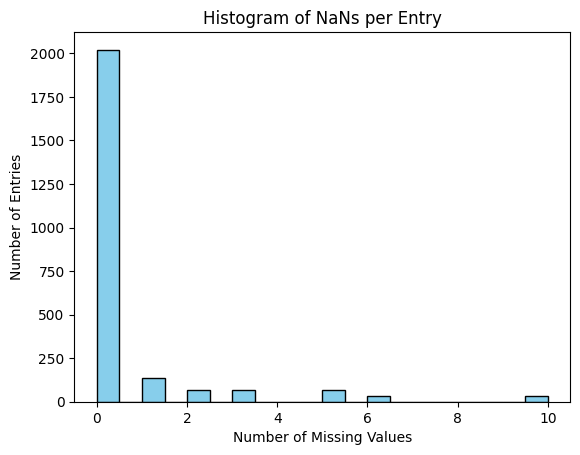

In [10]:
#Check for missing data (NaNs)
missing_data_count = np.isnan(testdata).sum(axis=1)  # Sum of NaNs per row

# Step 2: Create a histogram of NaN counts per entry
plt.hist(missing_data_count, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of NaNs per Entry')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Entries')
plt.show()

In [11]:
# no entry missing more than 4 bins, so OK to do imputation across all
# Impute missing values with the mean of each column
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Create an imputer object
imputer = IterativeImputer()

# Fit the imputer on the dataset and transform it
testdata_imputed = imputer.fit_transform(testdata)

print(testdata_imputed)

[[ 1.90676069  1.28546166  1.37217975 ...  1.11211801  0.79652089
   0.97804004]
 [ 1.03780603  0.45109859  0.63615572 ... -0.21139055 -0.24098152
  -0.29926962]
 [ 0.72188145  0.39421722  0.56956357 ... -0.39296615 -0.52536875
  -0.66517699]
 ...
 [-2.88129115 -2.40382338 -2.6138289  ... -2.49045801 -2.27920532
  -2.65424705]
 [-1.02136922 -1.13702655 -0.88074243 ... -0.17178266 -0.36299136
  -0.0449677 ]
 [-1.98993111 -1.87736845 -2.2727828  ... -1.51971745 -1.74100983
  -1.28633499]]


# Train and test model with nested cross-validation:

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut, RandomizedSearchCV, KFold
from imblearn.ensemble import BalancedRandomForestClassifier  # Updated import
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import clone
import multiprocessing
import json

# Function to serialize results to handle non-serializable types
def serialize_for_json(obj):
    if isinstance(obj, np.int64):
        return int(obj)
    elif isinstance(obj, np.float64):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()  # Convert numpy arrays to lists
    return obj

# Get data
X = testdata_imputed
y = testlabels
groups = np.array(allsubs)

# Define hyperparameter search space
param_dist = {
    'n_estimators': np.arange(100, 5000, 50),
    'max_features': np.arange(2, 100, 2),
    'max_samples': np.arange(10, 40, 2)
}

numiter = 1000

# Define the inner and outer CV strategies
inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
outer_cv = LeaveOneGroupOut()

# Function to evaluate model and return metrics
def evaluate_model(train_index, test_index, groups, model, X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='micro'),
        'recall': recall_score(y_test, y_pred, average='micro'),
        'f1_score': f1_score(y_test, y_pred, average='micro'),
    }

    return metrics, y_test, y_pred

# Function to compute feature importance
def compute_feature_importance(model, X_train):
    # Get feature importances directly from the BalancedRandomForest model
    feature_importances = model.feature_importances_
    return feature_importances

# Function to run nested CV for each split
def nested_cv_for_split(split):
    train_index, test_index = split
    group = groups[test_index[0]]  # Get the group (subject) for the test index
    model = BalancedRandomForestClassifier(class_weight='balanced', random_state=42,
                                          bootstrap=False,
                                          sampling_strategy='all',
                                          replacement=True)  # Changed to BalancedRandomForestClassifier

    # Print when starting the loop for each group (split)
    print(f"Starting Outer Loop for Group: {group}...")

    # Get the condition labels for the training and testing data
    train_conditions = y[train_index]
    test_conditions = y[test_index]
    
    # Select training data: conditions W and N
    train_condition_mask = np.isin(train_conditions, [1, 2])  # Select only W and N
    X_train = X[train_index][train_condition_mask]
    y_train = train_conditions[train_condition_mask]
    
    # Double-check the unique values in y_train to ensure only 1 and 2 are included
    print(f"Unique values in y_train for Group {group}: {np.unique(y_train)}")
    
    # Select testing data: conditions W and N (exclude class 3 completely from testing)
    test_condition_mask = np.isin(test_conditions, [1, 2, 3])  # Select conditions for testing
    X_test = X[test_index][test_condition_mask]
    y_test = test_conditions[test_condition_mask]

    # Double-check the unique values in y_test to ensure only 1 and 2 are included
    #print(f"Unique values in y_test for Group {group}: {np.unique(y_test)}")

    # Track the train/test split details for the left-out subject
    left_out_subject = group
    train_subjects = groups[train_index][train_condition_mask]
    test_subjects = groups[test_index][test_condition_mask]

    # Create a DataFrame to store the train/test info for the split
    split_info = pd.DataFrame({
        'split': [len(split_details)] * (len(train_subjects) + len(test_subjects)),  # Split number (fold)
        'left_out_subject': [left_out_subject] * (len(train_subjects) + len(test_subjects)),  # Left-out subject
        'subject': np.concatenate([train_subjects, test_subjects]),  # Concatenate subjects from train and test
        'set': ['train'] * len(train_subjects) + ['test'] * len(test_subjects),  # Train or test
        'condition': np.concatenate([y_train, y_test])  # Conditions (W, N) for each subject
    })
    
    # Print when RandomizedSearchCV is starting
    print(f"  Running RandomizedSearchCV for Group: {group}...")

    # Inner CV using RandomizedSearchCV
    search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, 
                                n_iter=numiter, cv=inner_cv, random_state=1, refit=True)
    search.fit(X_train, y_train)

    # Convert np.int64 to regular Python int
    best_params = {
        'n_estimators': int(search.best_params_['n_estimators']),
        'max_samples': int(search.best_params_['max_samples']),
        'max_features': int(search.best_params_['max_features'])
    }
    
    print(f"  Finished RandomizedSearchCV for Group: {group}. Best Params: {best_params}")

    best_model = clone(search.best_estimator_)
    metrics, true_labels, predicted_labels = evaluate_model(train_index[train_condition_mask], test_index[test_condition_mask], groups, best_model, X, y)
    
    # Store the metrics
    metrics['group'] = group
    
    # Get the feature importance from the trained model
    feature_importances = compute_feature_importance(best_model, X_train)
    
    # Store the feature importances along with the metrics
    metrics['feature_importances'] = feature_importances.tolist()

    # Create a dataframe for results: subject, label, and predicted label
    results_df = pd.DataFrame({
        'subject': np.repeat(group, len(true_labels)),
        'true_label': true_labels,
        'predicted_label': predicted_labels
    })
    
    # Print when the loop for the group has finished
    print(f"  Completed processing for Group: {group}.")

    # Return metrics, split details, and results for this split
    return metrics, split_info, results_df

# Initialize a list to collect all results
results = []
split_details = []  # List to collect all split details
all_predictions = []

# Run outer CV with parallel processing and collect output
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    outer_results = pool.map(nested_cv_for_split, outer_cv.split(X, y, groups))

    # Collect and print status
    total_splits = len(list(outer_cv.split(X, y, groups)))  # Total number of splits
    for i, (metrics, split_info, results_df) in enumerate(outer_results):
        # Print status after each outer CV fold is completed
        print(f"Outer CV Split {i+1}/{total_splits} completed.")
        
        # Add the results and split details to the main lists
        results.append(metrics)
        split_details.append(split_info)
        all_predictions.append(results_df)

# Concatenate all split details into a single DataFrame for easy analysis
split_details_df = pd.concat(split_details, ignore_index=True)

# Save the split details to a CSV for inspection
split_details_df.to_csv('PCC_balanced_WNR_train_test_split_details.csv', index=False)

# Combine all prediction dataframes into one
predictions_df = pd.concat(all_predictions, ignore_index=True)

# Save results to a text file (metrics)
with open('PCC_balanced_WNR_model_cv_results_with_importance.txt', 'w') as f:
    for res in results:
        f.write(json.dumps({key: serialize_for_json(value) for key, value in res.items()}) + '\n')

# Save the prediction results to CSV
predictions_df.to_csv('PCC_balanced_WNRpredictions.csv', index=False)

# Print out the results DataFrame
print(f"Unique values in final true values: {predictions_df['true_label'].unique()}")
print(f"Unique values in final predictions: {predictions_df['predicted_label'].unique()}")

# Calculate averages and print them
avg_metrics = {}
# Loop through the metrics in each outer CV fold
for i, (metrics, split_info, results_df) in enumerate(outer_results):
    for key in metrics.keys():
        if key not in ['split_index', 'group', 'feature_importance_mean', 'feature_importance_std']:
            if key not in avg_metrics:
                avg_metrics[key] = []
            avg_metrics[key].append(metrics[key])

# Now calculate the average, median, min, and max for each metric
for key, values in avg_metrics.items():
    avg = np.mean(values)
    median = np.median(values)
    minimum = np.min(values)
    maximum = np.max(values)
    
    # Store the metrics in the dictionary
    avg_metrics[key] = {
        'average': avg,
        'median': median,
        'min': minimum,
        'max': maximum
    }

# Print metrics and feature importance summary
print("Training Metrics:")
for key, metrics in avg_metrics.items():
    print(f"{key}: Mean = {metrics['average']:.4f}, Median = {metrics['median']:.4f}, Minimum = {metrics['min']:.4f}, Maximum = {metrics['max']:.4f}")


Starting Outer Loop for Group: 101...Starting Outer Loop for Group: 102...Starting Outer Loop for Group: 103...Starting Outer Loop for Group: 106...Starting Outer Loop for Group: 104...Starting Outer Loop for Group: 107...Starting Outer Loop for Group: 105...
Starting Outer Loop for Group: 111...Starting Outer Loop for Group: 108...Starting Outer Loop for Group: 110...
Starting Outer Loop for Group: 113...Starting Outer Loop for Group: 117...Starting Outer Loop for Group: 112...
Starting Outer Loop for Group: 119...Starting Outer Loop for Group: 122...Starting Outer Loop for Group: 125...Starting Outer Loop for Group: 123...




Starting Outer Loop for Group: 126...Starting Outer Loop for Group: 127...

Starting Outer Loop for Group: 124...Starting Outer Loop for Group: 128...
Starting Outer Loop for Group: 129...Starting Outer Loop for Group: 132...

Starting Outer Loop for Group: 133...
Starting Outer Loop for Group: 131...Starting Outer Loop for Group: 134...


Starting Outer Loop f

/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 331. Best Params: {'n_estimators': 150, 'max_samples': 38, 'max_features': 58}
  Completed processing for Group: 331.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 101. Best Params: {'n_estimators': 650, 'max_samples': 24, 'max_features': 4}
  Completed processing for Group: 101.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 307. Best Params: {'n_estimators': 4350, 'max_samples': 12, 'max_features': 2}
  Completed processing for Group: 307.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 138. Best Params: {'n_estimators': 3050, 'max_samples': 38, 'max_features': 4}
  Completed processing for Group: 138.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 128. Best Params: {'n_estimators': 1700, 'max_samples': 34, 'max_features': 16}


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 348. Best Params: {'n_estimators': 600, 'max_samples': 12, 'max_features': 28}
  Completed processing for Group: 128.
  Completed processing for Group: 348.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 136. Best Params: {'n_estimators': 1600, 'max_samples': 14, 'max_features': 80}
  Completed processing for Group: 136.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 209. Best Params: {'n_estimators': 500, 'max_samples': 26, 'max_features': 36}
  Finished RandomizedSearchCV for Group: 140. Best Params: {'n_estimators': 650, 'max_samples': 22, 'max_features': 2}
  Completed processing for Group: 140.
  Completed processing for Group: 209.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 342. Best Params: {'n_estimators': 1550, 'max_samples': 36, 'max_features': 14}
  Completed processing for Group: 342.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 316. Best Params: {'n_estimators': 250, 'max_samples': 20, 'max_features': 76}
  Completed processing for Group: 316.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 203. Best Params: {'n_estimators': 600, 'max_samples': 36, 'max_features': 62}
  Finished RandomizedSearchCV for Group: 117. Best Params: {'n_estimators': 2350, 'max_samples': 36, 'max_features': 74}
  Completed processing for Group: 203.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 304. Best Params: {'n_estimators': 150, 'max_samples': 18, 'max_features': 24}
  Completed processing for Group: 304.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Completed processing for Group: 117.
  Finished RandomizedSearchCV for Group: 125. Best Params: {'n_estimators': 150, 'max_samples': 18, 'max_features': 62}
  Completed processing for Group: 125.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 119. Best Params: {'n_estimators': 150, 'max_samples': 18, 'max_features': 62}


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Completed processing for Group: 119.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 110. Best Params: {'n_estimators': 100, 'max_samples': 36, 'max_features': 8}
  Completed processing for Group: 110.
  Finished RandomizedSearchCV for Group: 328. Best Params: {'n_estimators': 4700, 'max_samples': 38, 'max_features': 10}
  Completed processing for Group: 328.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 137. Best Params: {'n_estimators': 500, 'max_samples': 24, 'max_features': 20}
  Completed processing for Group: 137.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 305. Best Params: {'n_estimators': 200, 'max_samples': 18, 'max_features': 6}
  Completed processing for Group: 305.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 238. Best Params: {'n_estimators': 4600, 'max_samples': 30, 'max_features': 2}
  Completed processing for Group: 238.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 244. Best Params: {'n_estimators': 3850, 'max_samples': 32, 'max_features': 2}
  Completed processing for Group: 244.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 254. Best Params: {'n_estimators': 4600, 'max_samples': 30, 'max_features': 2}
  Completed processing for Group: 254.
  Finished RandomizedSearchCV for Group: 271. Best Params: {'n_estimators': 4650, 'max_samples': 20, 'max_features': 4}
  Completed processing for Group: 271.
  Finished RandomizedSearchCV for Group: 107. Best Params: {'n_estimators': 300, 'max_samples': 32, 'max_features': 86}


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 284. Best Params: {'n_estimators': 1000, 'max_samples': 12, 'max_features': 2}
  Completed processing for Group: 284.
  Completed processing for Group: 107.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 124. Best Params: {'n_estimators': 2350, 'max_samples': 28, 'max_features': 22}


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 269. Best Params: {'n_estimators': 1700, 'max_samples': 38, 'max_features': 2}
  Completed processing for Group: 269.
  Completed processing for Group: 124.
  Finished RandomizedSearchCV for Group: 106. Best Params: {'n_estimators': 1800, 'max_samples': 10, 'max_features': 58}
  Completed processing for Group: 106.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 210. Best Params: {'n_estimators': 1750, 'max_samples': 14, 'max_features': 6}
  Completed processing for Group: 210.
  Finished RandomizedSearchCV for Group: 135. Best Params: {'n_estimators': 700, 'max_samples': 36, 'max_features': 66}
  Completed processing for Group: 135.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 108. Best Params: {'n_estimators': 350, 'max_samples': 16, 'max_features': 84}
  Completed processing for Group: 108.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 207. Best Params: {'n_estimators': 1750, 'max_samples': 14, 'max_features': 6}
  Completed processing for Group: 207.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 319. Best Params: {'n_estimators': 3000, 'max_samples': 22, 'max_features': 8}
  Completed processing for Group: 319.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 217. Best Params: {'n_estimators': 250, 'max_samples': 32, 'max_features': 98}
  Completed processing for Group: 217.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 325. Best Params: {'n_estimators': 4100, 'max_samples': 12, 'max_features': 14}
  Completed processing for Group: 325.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 129. Best Params: {'n_estimators': 1700, 'max_samples': 30, 'max_features': 52}
  Completed processing for Group: 129.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 333. Best Params: {'n_estimators': 200, 'max_samples': 28, 'max_features': 10}
  Completed processing for Group: 333.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 317. Best Params: {'n_estimators': 1300, 'max_samples': 20, 'max_features': 2}
  Completed processing for Group: 317.
  Finished RandomizedSearchCV for Group: 131. Best Params: {'n_estimators': 3150, 'max_samples': 30, 'max_features': 98}


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 212. Best Params: {'n_estimators': 150, 'max_samples': 32, 'max_features': 22}
  Completed processing for Group: 212.
  Completed processing for Group: 131.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 127. Best Params: {'n_estimators': 300, 'max_samples': 34, 'max_features': 22}
  Completed processing for Group: 127.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 290. Best Params: {'n_estimators': 3250, 'max_samples': 22, 'max_features': 2}
  Completed processing for Group: 290.
  Finished RandomizedSearchCV for Group: 201. Best Params: {'n_estimators': 300, 'max_samples': 20, 'max_features': 58}
  Completed processing for Group: 201.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 270. Best Params: {'n_estimators': 1300, 'max_samples': 20, 'max_features': 2}
  Completed processing for Group: 270.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 126. Best Params: {'n_estimators': 550, 'max_samples': 28, 'max_features': 70}
  Completed processing for Group: 126.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 139. Best Params: {'n_estimators': 150, 'max_samples': 18, 'max_features': 62}
  Completed processing for Group: 139.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 104. Best Params: {'n_estimators': 700, 'max_samples': 36, 'max_features': 24}


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 206. Best Params: {'n_estimators': 150, 'max_samples': 38, 'max_features': 58}
  Completed processing for Group: 104.
  Completed processing for Group: 206.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 286. Best Params: {'n_estimators': 650, 'max_samples': 24, 'max_features': 4}
  Completed processing for Group: 286.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 133. Best Params: {'n_estimators': 350, 'max_samples': 16, 'max_features': 84}
  Completed processing for Group: 133.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 111. Best Params: {'n_estimators': 850, 'max_samples': 18, 'max_features': 94}
  Finished RandomizedSearchCV for Group: 112. Best Params: {'n_estimators': 600, 'max_samples': 34, 'max_features': 82}
  Finished RandomizedSearchCV for Group: 132. Best Params: {'n_estimators': 2950, 'max_samples': 34, 'max_features': 56}
  Completed processing for Group: 112.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Completed processing for Group: 111.
  Finished RandomizedSearchCV for Group: 247. Best Params: {'n_estimators': 4350, 'max_samples': 12, 'max_features': 2}
  Completed processing for Group: 247.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 264. Best Params: {'n_estimators': 500, 'max_samples': 32, 'max_features': 2}
  Completed processing for Group: 264.
  Completed processing for Group: 132.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 234. Best Params: {'n_estimators': 150, 'max_samples': 26, 'max_features': 68}
  Completed processing for Group: 234.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 293. Best Params: {'n_estimators': 2050, 'max_samples': 32, 'max_features': 4}


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 205. Best Params: {'n_estimators': 4350, 'max_samples': 24, 'max_features': 58}
  Completed processing for Group: 293.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 226. Best Params: {'n_estimators': 2300, 'max_samples': 36, 'max_features': 8}
  Finished RandomizedSearchCV for Group: 335. Best Params: {'n_estimators': 350, 'max_samples': 16, 'max_features': 22}
  Completed processing for Group: 335.
  Completed processing for Group: 226.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 113. Best Params: {'n_estimators': 1150, 'max_samples': 22, 'max_features': 74}


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 339. Best Params: {'n_estimators': 200, 'max_samples': 12, 'max_features': 74}
  Completed processing for Group: 113.
  Completed processing for Group: 339.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 122. Best Params: {'n_estimators': 150, 'max_samples': 26, 'max_features': 68}
  Completed processing for Group: 205.
  Completed processing for Group: 122.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 105. Best Params: {'n_estimators': 100, 'max_samples': 36, 'max_features': 8}
  Completed processing for Group: 105.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 211. Best Params: {'n_estimators': 100, 'max_samples': 30, 'max_features': 28}
  Completed processing for Group: 211.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 235. Best Params: {'n_estimators': 150, 'max_samples': 22, 'max_features': 90}
  Completed processing for Group: 235.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 134. Best Params: {'n_estimators': 1400, 'max_samples': 12, 'max_features': 36}
  Completed processing for Group: 134.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 103. Best Params: {'n_estimators': 2100, 'max_samples': 20, 'max_features': 56}
  Completed processing for Group: 103.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 102. Best Params: {'n_estimators': 600, 'max_samples': 16, 'max_features': 64}
  Completed processing for Group: 102.


/home/westbrookca2/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Finished RandomizedSearchCV for Group: 123. Best Params: {'n_estimators': 2450, 'max_samples': 18, 'max_features': 46}
  Completed processing for Group: 123.
  Finished RandomizedSearchCV for Group: 251. Best Params: {'n_estimators': 2600, 'max_samples': 16, 'max_features': 2}
  Completed processing for Group: 251.
Outer CV Split 1/72 completed.
Outer CV Split 2/72 completed.
Outer CV Split 3/72 completed.
Outer CV Split 4/72 completed.
Outer CV Split 5/72 completed.
Outer CV Split 6/72 completed.
Outer CV Split 7/72 completed.
Outer CV Split 8/72 completed.
Outer CV Split 9/72 completed.
Outer CV Split 10/72 completed.
Outer CV Split 11/72 completed.
Outer CV Split 12/72 completed.
Outer CV Split 13/72 completed.
Outer CV Split 14/72 completed.
Outer CV Split 15/72 completed.
Outer CV Split 16/72 completed.
Outer CV Split 17/72 completed.
Outer CV Split 18/72 completed.
Outer CV Split 19/72 completed.
Outer CV Split 20/72 completed.
Outer CV Split 21/72 completed.
Outer CV Split 22/

# Feature importance

/tmp/ipykernel_3340612/2549971374.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=long_form_df, x='Decrease in Accuracy', y='Feature', width=0.6, palette='viridis')


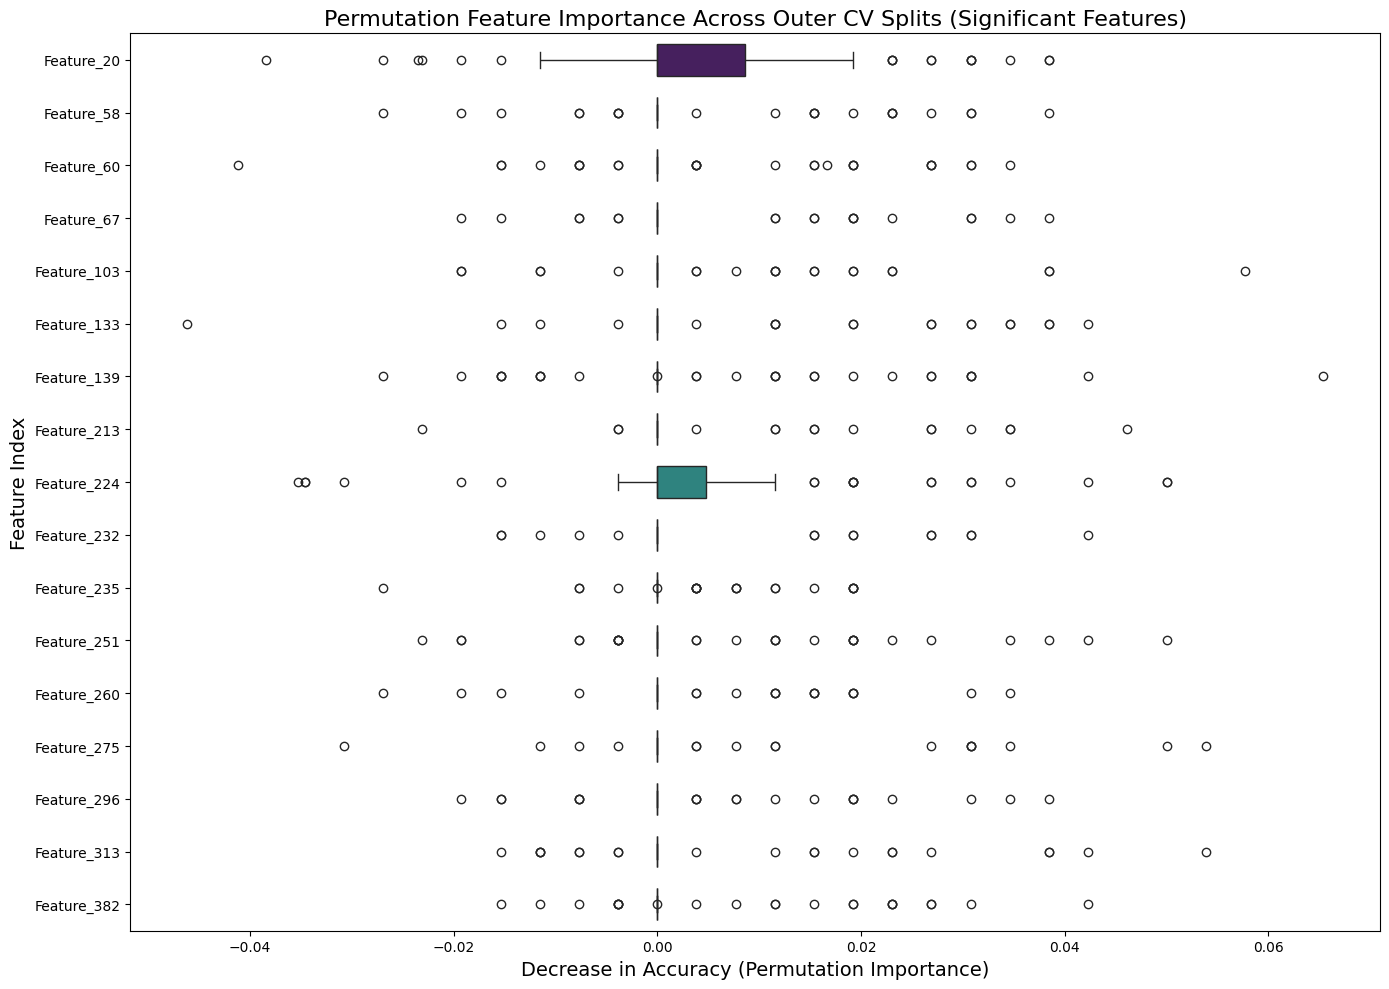

In [39]:
# code to plot the feature importance
# this will run a t-test and eliminate features whose importance is not significantly different from zero.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from scipy import stats  # Import for t-test

# Assuming you already have `outer_results` with feature importance data (mean and std)

# Step 1: Extract feature importance values from the outer CV results
feature_importance_list = []

for res in outer_results:
    feature_importance_list.append(res[0]['feature_importance_mean'])

# Convert to a DataFrame where each row corresponds to a feature across all splits
feature_importance_matrix = np.array(feature_importance_list)  # Shape: (n_splits, n_features)
n_features = feature_importance_matrix.shape[1]

# Step 2: Perform a t-test for each feature's importance
p_values = []
for i in range(n_features):
    t_stat, p_value = stats.ttest_1samp(feature_importance_matrix[:, i], 0)  # Test if mean is different from 0
    p_values.append(p_value)

# Step 3: Filter features with p-values < 0.05 (significant)
significant_features = np.array(p_values) < 0.05

# Filter the feature importance matrix to include only significant features
filtered_feature_importance_matrix = feature_importance_matrix[:, significant_features]

# Step 4: Create a DataFrame with the filtered feature importances
filtered_feature_importance_df = pd.DataFrame(
    filtered_feature_importance_matrix,
    columns=[f"Feature_{i+1}" for i in range(n_features) if significant_features[i]]
)

# Convert DataFrame to long-form for easier plotting with Seaborn
long_form_df = filtered_feature_importance_df.melt(var_name='Feature', value_name='Decrease in Accuracy')

# Step 5: Plot boxplot for significant features only
plt.figure(figsize=(14, 10))
sns.boxplot(data=long_form_df, x='Decrease in Accuracy', y='Feature', width=0.6, palette='viridis')

# Add title and labels
plt.title('Permutation Feature Importance Across Outer CV Splits (Significant Features)', fontsize=16)
plt.xlabel('Decrease in Accuracy (Permutation Importance)', fontsize=14)
plt.ylabel('Feature Index', fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

# Optionally, save the plot
# plt.savefig('significant_feature_importance_boxplot.png')



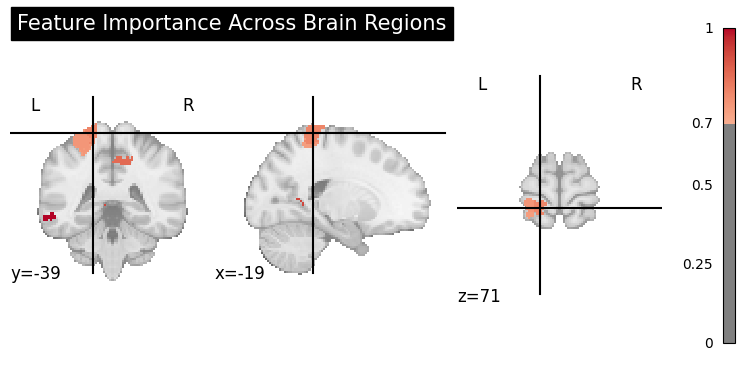

In [65]:
# visualize in the brain
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, datasets
from matplotlib import cm
import nibabel as nib

# Step 1: Fetch the Schaefer 400-parcellation (this will give you the NIfTI file)
schaefer_400 = datasets.fetch_atlas_schaefer_2018(n_rois=400)

# The filename is the path to the NIfTI file of the Schaefer 400 parcellation
atlas_filename = '/home/westbrookca2/nilearn_data/schaefer_2018/rSchaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii'

# Step 2: Assuming `feature_importance_df` is a DataFrame with shape (72, 400),
# where each column corresponds to a region, we calculate the mean feature importance
# Calculate the mean importance across subjects for each region
feature_importance_mean = feature_importance_df['Mean Importance']

# Step 3: Normalize the importance scores and delete out non-significant ones
importance_scaled = (feature_importance_mean - np.min(feature_importance_mean)) / (np.max(feature_importance_mean) - np.min(feature_importance_mean))
importance_scaled[~significant_features] = 0

# Step 4: Load the Schaefer 400 parcellation image (NIfTI file)
atlas_img = nib.load(atlas_filename)

# Step 5: Create a 3D image where each region of the brain is assigned its corresponding importance score
importance_img_data = np.zeros(atlas_img.shape)

# Map the normalized importance values to each region in the parcellation
for i in range(1, 401):  # Parcellation regions are labeled from 1 to 400
    region_mask = (atlas_img.get_fdata() == i)  # Get the voxels of the current region
    importance_img_data[region_mask] = importance_scaled[i-1]  # Assign the normalized importance value

# Step 6: Create a new NIfTI image with the importance values for visualization
importance_img = nib.Nifti1Image(importance_img_data, affine=atlas_img.affine)

# Step 7: Visualize the brain regions with feature importance using nilearn
# Use plot_stat_map to visualize the importance values across the brain
colormap = plt.colormaps.get_cmap('coolwarm')  # Choose a color map

plotting.plot_stat_map(importance_img, title="Feature Importance Across Brain Regions",
                       display_mode='ortho', draw_cross=True, colorbar=True, cmap=colormap, threshold=0.7)

# Show the plot
plt.show()

# Save the NIfTI image to a file
nifti_filename = "feature_importance_WNR_model_schaefer400.nii.gz"  # Set the output filename
nib.save(importance_img, nifti_filename)

In [66]:
importance_scaled

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
395    0.0
396    0.0
397    0.0
398    0.0
399    0.0
Name: Mean Importance, Length: 400, dtype: float64